In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso, Ridge, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

### Ridge Model - Predicting Reports

In [303]:
hikes = pd.read_csv('../data/wta-parks-data.csv', sep='\t', index_col=0)
hikes_model = hikes.drop(columns=['description','url','name','pass: None','votes', 'lat','lon','drive distance']).dropna()
# hikes_model = hikes[['reports','length','gain','drive time','technical','pass: None']].dropna()

## Model on Reports feature

In [428]:
X = hikes_model.drop(columns=['reports','rating']).values
y = hikes_model['reports'].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [429]:
nalphas = 50
min_alpha_exp = 1
max_alpha_exp = 6
nfeatures = X.shape[1]
coefs = np.zeros((nalphas, nfeatures))
alphas = np.logspace(min_alpha_exp, max_alpha_exp, nalphas)
mse_train = np.zeros(nalphas)
mse_test = np.zeros(nalphas)
for idx, alpha in enumerate(alphas):
    model = Pipeline([('standardize', StandardScaler()),
                     ('ridge', RidgeCV(alphas=[alpha], cv=10))])
    model.fit(X_train, y_train)
    coefs[idx] = model.steps[1][1].coef_
    mse_train[idx] = mean_squared_error(y_train, model.predict(X_train))
    mse_test[idx] = mean_squared_error(y_test, model.predict(X_test))

nalphas = 50
min_alpha_exp = 1
max_alpha_exp = 6
nfeatures = X.shape[1]
coefs = np.zeros((nalphas, nfeatures))
alphas = np.logspace(min_alpha_exp, max_alpha_exp, nalphas)
mse_train = np.zeros(nalphas)
mse_test = np.zeros(nalphas)
x_scaler = StandardScaler()
y_scaler = StandardScaler()
x_scaler.fit(X_train)
y_scaler.fit(y_train.reshape(-1,1))
X_train_scaled = x_scaler.transform(X_train)
X_test_scaled = x_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train.reshape(-1,1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))

for idx, alpha in enumerate(alphas):
    model = RidgeCV(alphas=[alpha], cv=10)
    model.fit(X_train_scaled, y_train_scaled)
    coefs[idx] = model.coef_
    y_pred_train = y_scaler.inverse_transform(model.predict(X_train_scaled))
    y_pred_test = y_scaler.inverse_transform(model.predict(X_test_scaled))
    mse_train[idx] = mean_squared_error(y_train, y_pred_train)
    mse_test[idx] = mean_squared_error(y_test, y_pred_test)

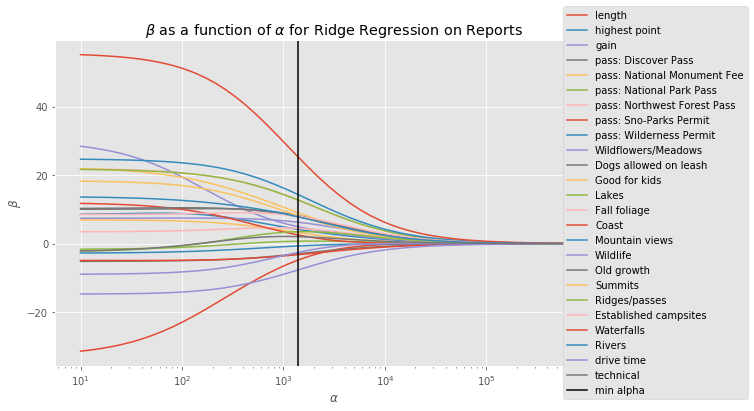

In [430]:
fig, ax = plt.subplots(figsize=(10,6))
for feature in range(nfeatures):
    ax.plot(alphas, coefs[:, feature],
             label=columns[feature])

ax.axvline(alphas[(np.argmin(mse_test))], label='min alpha', color='k')
ax.set_xscale('log')
ax.set_title("$\\beta$ as a function of $\\alpha$ for Ridge Regression on Reports")
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.legend(loc="right", bbox_to_anchor=(1.25, .5), framealpha=1)
fig.savefig('../images/reports_ridge_beta_vs_alpha.png', bbox_inches='tight', dpi=350)

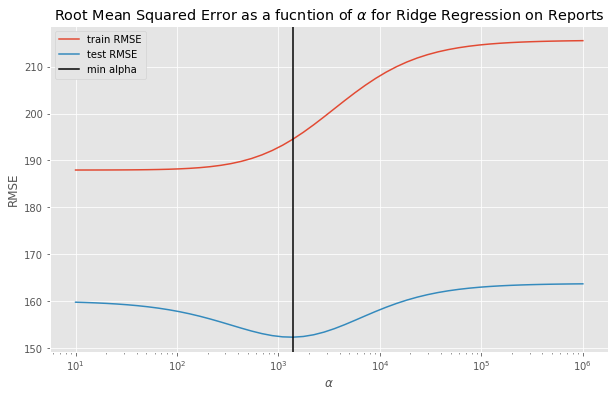

In [431]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(alphas, np.sqrt(mse_train), label='train RMSE')
ax.plot(alphas, np.sqrt(mse_test), label='test RMSE')
ax.axvline(alphas[(np.argmin(mse_test))], label='min alpha', color='k')
ax.set_xscale('log')
ax.set_title('Root Mean Squared Error as a fucntion of $\\alpha$ for Ridge Regression on Reports')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("RMSE")
ax.legend(loc='best', framealpha=1)
fig.savefig('../images/reports_ridge_rmse.png', bbox_inches='tight', dpi=350)

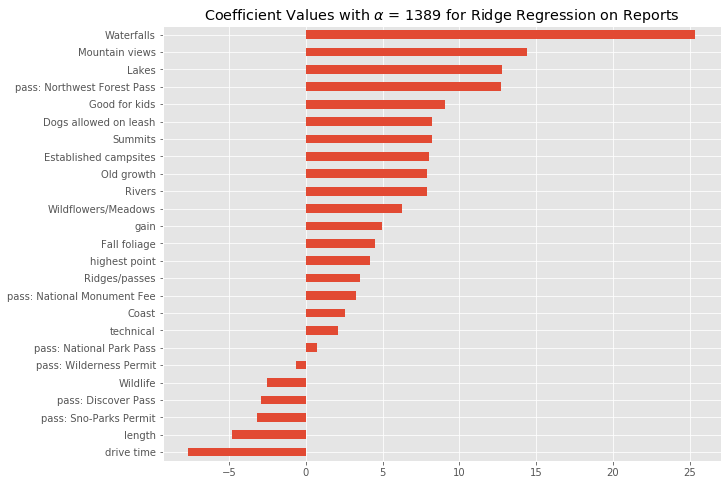

In [432]:
min_alpha = alphas[(np.argmin(mse_test))]
model = Pipeline([('standardize', StandardScaler()),
                     ('ridge', RidgeCV(alphas=[min_alpha], cv=10))])
model.fit(X_train, y_train)
ridge_coefs = model.steps[1][1].coef_

ridge_coefs = pd.DataFrame({'Coefficients': model.steps[1][1].coef_}, 
                       index=columns)

reports_ridge_coefs = ridge_coefs.sort_values(by='Coefficients')
reports_ridge_coefs.plot(kind='barh', figsize=(10,8), legend=False)
plt.title("Coefficient Values with $\\alpha$ = %.0f for Ridge Regression on Reports" % min_alpha)
plt.savefig("../images/reports_ridge_coefs_bar.png", bbox_inches='tight', dpi=350)

In [433]:
feat = 'reports'
print(f"The average {feat} value is {np.mean(hikes_model[feat]):.2f}.")
print(f"The standard deviation of the {feat} value is {np.std(hikes_model[feat]):.2f}.")
print(f"The model RMSE predicting the {feat} value is {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.2f}.")

The average reports value is 110.61.
The standard deviation of the reports value is 203.82.
The model RMSE predicting the reports value is 152.35.


## Model on Rating feature

In [435]:
X = hikes_model.drop(columns=['reports','rating']).values
y = hikes_model['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y)
columns = hikes_model.drop(columns=['reports','rating']).columns

In [436]:
nalphas = 50
min_alpha_exp = 1
max_alpha_exp = 6
nfeatures = X.shape[1]
coefs = np.zeros((nalphas, nfeatures))
alphas = np.logspace(min_alpha_exp, max_alpha_exp, nalphas)
mse_train = np.zeros(nalphas)
mse_test = np.zeros(nalphas)
for idx, alpha in enumerate(alphas):
    model = Pipeline([('standardize', StandardScaler()),
                     ('ridge', RidgeCV(alphas=[alpha], cv=10))])
    model.fit(X_train, y_train)
    coefs[idx] = model.steps[1][1].coef_
    mse_train[idx] = mean_squared_error(y_train, model.predict(X_train))
    mse_test[idx] = mean_squared_error(y_test, model.predict(X_test))

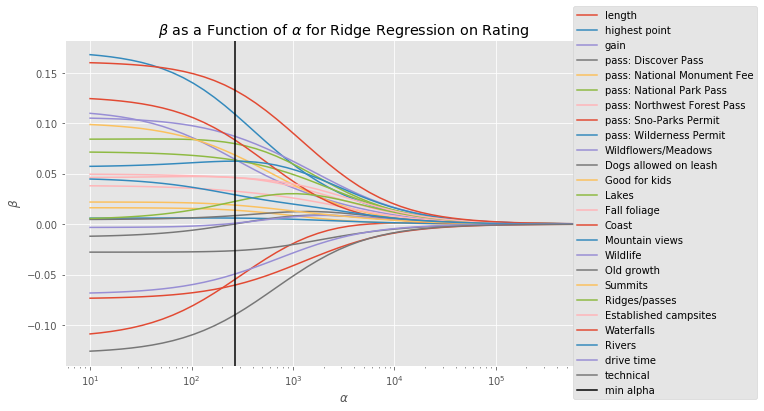

In [437]:
fig, ax = plt.subplots(figsize=(10,6))
for feature in range(nfeatures):
    ax.plot(alphas, coefs[:, feature],
             label=columns[feature])

ax.axvline(alphas[(np.argmin(mse_test))], label='min alpha', color='k')
ax.set_xscale('log')
ax.set_title("$\\beta$ as a Function of $\\alpha$ for Ridge Regression on Rating")
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.legend(loc="right", bbox_to_anchor=(1.25, .5), framealpha=1)
fig.savefig('../images/rating_ridge_beta_vs_alpha.png', bbox_inches='tight', dpi=350)

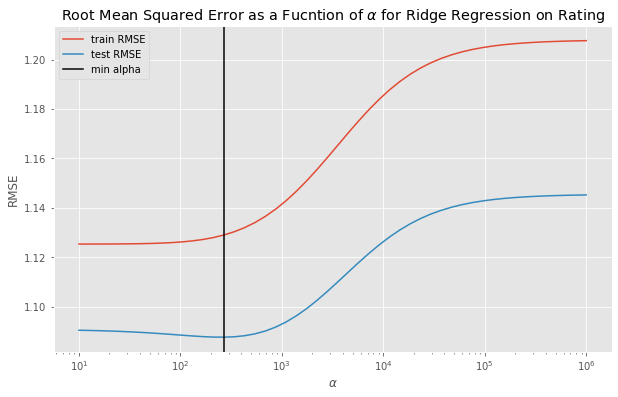

In [438]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(alphas, np.sqrt(mse_train), label='train RMSE')
ax.plot(alphas, np.sqrt(mse_test), label='test RMSE')
ax.axvline(alphas[(np.argmin(mse_test))], label='min alpha', color='k')
ax.set_xscale('log')
ax.set_title('Root Mean Squared Error as a Fucntion of $\\alpha$ for Ridge Regression on Rating')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("RMSE")
ax.legend(loc='best', framealpha=1)
fig.savefig('../images/rating_ridge_rmse.png', bbox_inches='tight', dpi=350)

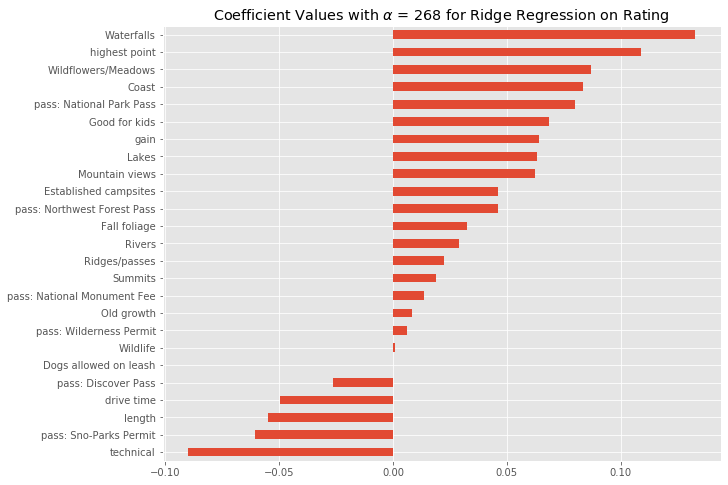

In [439]:
min_alpha = alphas[(np.argmin(mse_test))]
model = Pipeline([('standardize', StandardScaler()),
                     ('ridge', RidgeCV(alphas=[min_alpha], cv=10))])
model.fit(X_train, y_train)
ridge_coefs = model.steps[1][1].coef_

ridge_coefs = pd.DataFrame({'Coefficients': model.steps[1][1].coef_}, 
                       index=columns)

rating_ridge_coefs = ridge_coefs.sort_values(by='Coefficients')
rating_ridge_coefs.plot(kind='barh', figsize=(10,8), legend=False)
plt.title("Coefficient Values with $\\alpha$ = %.0f for Ridge Regression on Rating" % min_alpha)
plt.savefig("../images/rating_ridge_coefs_bar.png", bbox_inches='tight', dpi=350)

In [440]:
feat = 'rating'
print(f"The average {feat} value is {np.mean(hikes_model[feat]):.2f}.")
print(f"The standard deviation of the {feat} value is {np.std(hikes_model[feat]):.2f}.")
print(f"The model RMSE predicting the {feat} value is {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.2f}.")

The average rating value is 3.20.
The standard deviation of the rating value is 1.19.
The model RMSE predicting the rating value is 1.09.


## Combined Plot

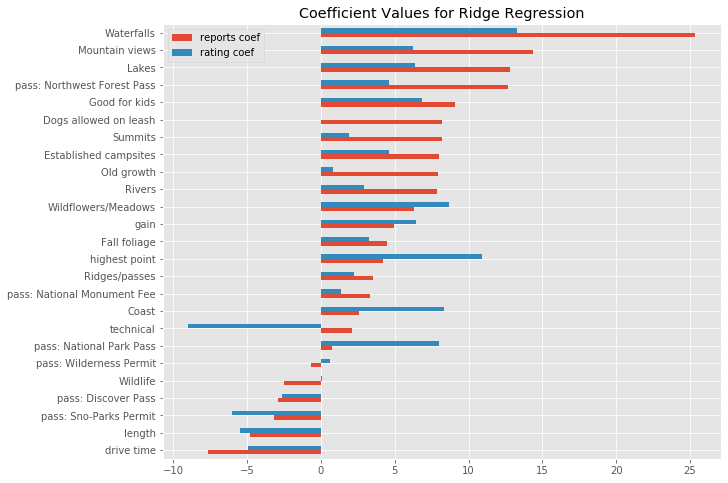

In [447]:
all_ridge_coefs = pd.concat([
    reports_ridge_coefs.rename(columns={'Coefficients':'reports coef'}), 
    rating_ridge_coefs.rename(columns={'Coefficients':'rating coef'})
], axis=1) 
all_ridge_coefs['rating coef'] = all_ridge_coefs['rating coef']*100
all_ridge_coefs.plot(kind='barh', figsize=(10,8), legend=True)
plt.title("Coefficient Values for Ridge Regression")
plt.savefig("../images/ridge_coefs_bar.png", bbox_inches='tight', dpi=350)

## Statsmodels Results Table

In [391]:
reports_model = sm.OLS(hikes_model['reports'], hikes_model.drop(columns=['reports','rating'])).fit()
summary = reports_model.summary()
reports_sum_df = pd.DataFrame(summary.tables[1]).drop(index=0).iloc[:,[0,1,4]].rename(columns={0:'feature',1:'reports coef',4:'reports p-value'})

In [392]:
rating_model = sm.OLS(hikes_model['rating'], hikes_model.drop(columns=['reports','rating'])).fit()
summary = rating_model.summary()
rating_sum_df = pd.DataFrame(summary.tables[1]).drop(index=0).iloc[:,[1,4]].rename(columns={1:'rating coef',4:'rating p-value'})

In [393]:
sum_df = pd.concat([reports_sum_df, rating_sum_df], axis=1)
sum_df

,feature,reports coef,reports p-value,rating coef,rating p-value
1,length,-2.5306,0.000,-0.0068,0.189
2,highest point,0.0026,0.358,0.0004,0.000
3,gain,0.0166,0.002,4.408e-05,0.264
4,pass: Discover Pass,-12.1523,0.510,0.6403,0.000
5,pass: National Monument Fee,157.6036,0.226,0.0974,0.921
6,pass: National Park Pass,-8.1689,0.692,0.2422,0.120
7,pass: Northwest Forest Pass,44.2028,0.000,0.1432,0.129
8,pass: Sno-Parks Permit,-52.6537,0.165,-0.2988,0.296
9,pass: Wilderness Permit,-79.4980,0.665,-0.1061,0.939
10,Wildflowers/Meadows,20.4010,0.084,0.2393,0.007


In [400]:
vals = np.array([ [-2.5306,	0.000,	-0.0068,	0.189],
[0.0026,	0.358,	0.0004,	0.000],
[0.0166,	0.002,	4.408e-05,	0.264],
[-12.1523,	0.510,	0.6403,	0.000],
[157.6036,	0.226,	0.0974,	0.921],
[-8.1689,	0.692,	0.2422,	0.120],
[44.2028,	0.000,	0.1432,	0.129],
[-52.6537,	0.165,	-0.2988,	0.296],
[-79.4980,	0.665,	-0.1061,	0.939],
[20.4010,	0.084,	0.2393,	0.007],
[14.0731,	0.247,	0.1298,	0.157],
[44.0796,	0.001,	0.9019,	0.000],
[49.0096,	0.000,	0.3407,	0.000],
[21.3554,	0.152,	-0.0167,	0.882],
[39.6841,	0.137,	1.7666	,0.000],
[46.7921,	0.000,	0.2181,	0.020],
[-12.1101,	0.307,	0.2309,	0.010],
[21.0239,	0.094,	0.3401,	0.000],
[35.6294,	0.018,	0.1096,	0.333],
[-7.3388,	0.606,	-0.1032,	0.337],
[30.2489,	0.032,	-0.1050,	0.323],
[134.2133,	0.000,	0.5784,	0.000],
[12.3975,	0.323,	0.5532,	0.000],
[-0.0765,	0.003,	0.0008,	0.000],
[-5.7098,	0.834,	-0.6192,	0.003]])
ind = np.array(['length',
'highest point', 'gain',
'pass: Discover Pass',
'pass: National Monument Fee',
'pass: National Park Pass',
'pass: Northwest Forest Pass',
'pass: Sno-Parks Permit',
'pass: Wilderness Permit',
'Wildflowers/Meadows',
'Dogs allowed on leash',
'Good for kids',
'Lakes',
'Fall foliage',
'Coast',
'Mountain views',
'Wildlife',
'Old growth',
'Summits',
'Ridges/passes',
'Established campsites',
'Waterfalls',
'Rivers',
'drive time',
'technical'])
sum_df = pd.DataFrame(data=vals, index=ind, columns=sum_df.columns[1:])

In [401]:
sum_df

,reports coef,reports p-value,rating coef,rating p-value
length,-2.5306,0.000,-0.006800,0.189
highest point,0.0026,0.358,0.000400,0.000
gain,0.0166,0.002,0.000044,0.264
pass: Discover Pass,-12.1523,0.510,0.640300,0.000
pass: National Monument Fee,157.6036,0.226,0.097400,0.921
pass: National Park Pass,-8.1689,0.692,0.242200,0.120
pass: Northwest Forest Pass,44.2028,0.000,0.143200,0.129
pass: Sno-Parks Permit,-52.6537,0.165,-0.298800,0.296
pass: Wilderness Permit,-79.4980,0.665,-0.106100,0.939
Wildflowers/Meadows,20.4010,0.084,0.239300,0.007


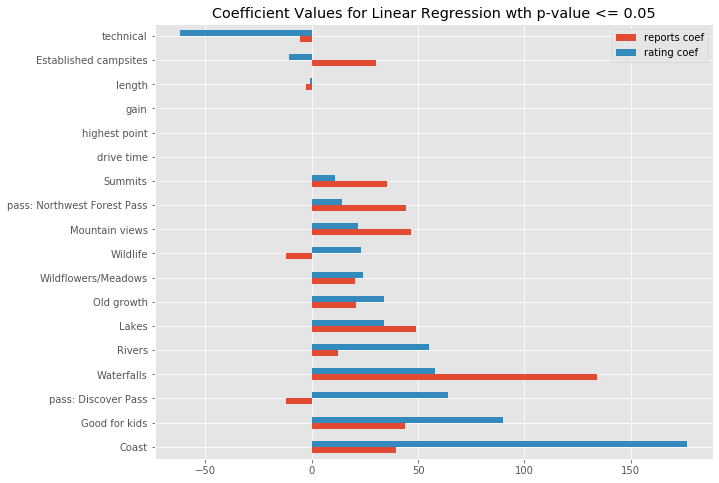

In [417]:
sum_df_plot = sum_df[(sum_df['reports p-value'].astype(float) <= 0.05) | (sum_df['rating p-value'].astype(float) <= 0.05)]
sum_df_plot = sum_df_plot.iloc[:,[0,2]].set_index(sum_df_plot.index).sort_values('rating coef', ascending=False)
sum_df_plot['rating coef'] = sum_df_plot['rating coef']*100
sum_df_plot.plot(kind='barh', figsize=(10,8), legend=True)
plt.title("Coefficient Values for Linear Regression wth p-value <= 0.05")
plt.savefig("../images/ols_coefs_bar.png", bbox_inches='tight', dpi=350)